## **Importing** **Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, pi
import cv2, os
from tqdm.auto import tqdm
from keras import layers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D,MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout
from keras.layers import ELU, PReLU, LeakyReLU
from typing import List
import numpy as np
from skimage.util import random_noise
from skimage import exposure

## **Mounting** **Drive**

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## **Importing** **Training** **Dataset**

In [3]:
# training = pd.read_csv('/content/drive/MyDrive/assignment/training.csv')
training = pd.read_csv('../Data/training.csv')

## **Data Exploration**

In [4]:
training.head()

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   
1          64.332936          34.970077           29.949277   
2          65.057053          34.909642           30.903789   
3          65.225739          37.261774           32.023096   
4          66.725301          39.621261           32.244810   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   
1           33.448715                58.856170                35.274349   
2           34.909642                59.412000                36.320968   
3           37.261774                60.003339                39.127179   
4           38.042032                58.565890                39.621261   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   
1                70.722723                36.187166                 36.034723   
2                70.984421                36.320968                 37.678105   
3                72.314713                38.380967                 37.618643   
4                72.515926                39.884466                 36.982380   

   right_eye_inner_corner_y  ...  nose_tip_y  mouth_left_corner_x  \
0                 37.389402  ...   57.066803            61.195308   
1                 34.361532  ...   55.660936            56.421447   
2                 36.320968  ...   53.538947            60.822947   
3                 38.754115  ...   54.166539            65.598887   
4                 39.094852  ...   64.889521            60.671411   

   mouth_left_corner_y  mouth_right_corner_x  mouth_right_corner_y  \
0            79.970165             28.614496             77.388992   
1            76.352000             35.122383             76.047660   
2            73.014316             33.726316             72.732000   
3            72.703722             37.245496             74.195478   
4            77.523239             31.191755             76.997301   

   mouth_center_top_lip_x  mouth_center_top_lip_y  mouth_center_bottom_lip_x  \
0               43.312602               72.935459                  43.130707   
1               46.684596               70.266553                  45.467915   
2               47.274947               70.191789                  47.274947   
3               50.303165               70.091687                  51.561183   
4               44.962748               73.707387                  44.227141   

   mouth_center_bottom_lip_y  \
0                  84.485774   
1                  85.480170   
2                  78.659368   
3                  78.268383   
4                  86.871166   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  
1  219 215 204 196 204 211 212 200 180 168 178 19...  
2  144 142 159 180 188 188 184 180 167 132 84 59 ...  
3  193 192 193 194 194 194 193 192 168 111 50 12 ...  
4  147 148 160 196 215 214 216 217 219 220 206 18...  

[5 rows x 31 columns]

In [5]:
training.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

## **Pipeline Functions**

### **Pre-Processing**

In [6]:
def null_drop(file):
  null_dropped_file=file.dropna()
  null_dropped_file.info()
  return null_dropped_file

In [7]:
def load_images(data_file):
  images_3D = []
  for index, row_data in data_file.iterrows():
    image = np.array([int(pixel) for pixel in row_data['Image'].split()])
    image = np.reshape(image, (96,96,1))
    images_3D.append(image)
  images_3D = np.array(images_3D)/255.
  print("Shape of output images: " , images_3D.shape)
  return images_3D



In [8]:
def load_keypoints(data_file):
    kp_data = data_file.drop('Image',axis = 1)
    kp_feat = []
    for index, row_data in kp_data.iterrows():
        kp_feat.append(row_data)
    kp_feat = np.array(kp_feat, dtype = 'float')
    print("Shape of output keypoints: " , kp_feat.shape)
    return kp_feat

In [9]:
def rand_img_selector(a,b):
  rand_sample=random.randint(a, b)
  print("The selected image sample is ", rand_sample)
  return rand_sample

In [10]:
def plot_kp(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [11]:
def plot_all_samples(samp_img_list,samp_kp_list,image_list_name):
  for i in range(len(samp_img_list)):
    image_list = samp_img_list[i]
    kp_list=samp_kp_list[i]
    print(f"\n Dataset Name:",image_list_name[i])
    #print("image_list is ", image_list)
    print("\n ")
    fig = plt.figure(figsize=(20,8))
    for j in range(5):
        axis = fig.add_subplot(1, 5, j+1, xticks=[], yticks=[])
        plot_kp(image_list[j], kp_list[j], axis, "")
    plt.show()


### **Augmentation Functions**

In [12]:
def concatenate(orig,aug):
  orig=np.concatenate((orig, aug))
  print("New shape of training data: ",orig.shape)
  return orig


In [13]:
def horz_flip(images, keypoints):
    # Flip images horizontally
    flipped_images = np.flip(images, axis=2)

    # Flip keypoints horizontally
    flipped_keypoints = []
    for sample_keypoints in keypoints:
        flipped_sample_keypoints = np.copy(sample_keypoints)
        flipped_sample_keypoints[::2] = 96.0 - flipped_sample_keypoints[::2]
        flipped_keypoints.append(flipped_sample_keypoints)

    print("Shape of flipped_train_images:", np.shape(flipped_images))
    print("Shape of flipped_train_keypoints:", np.shape(flipped_keypoints))
    return flipped_images, flipped_keypoints

In [14]:
def rotation(images, keypoints,rot_angle):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rot_angle:    # Loop over the list of angles to apply rotation augmentation to the images
        for angle in [angle,-angle]: # For each angle, apply rotation in clockwise and anti-clockwise directions
            print(f'{angle}', end='  ') # Print the current angle being processed
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0) # Get the 2D rotation matrix for the current angle and the center of the image
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC) # Apply the rotation to the current image using the 2D rotation matrix
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension from the current keypoint to adjust for the rotation center
                for idx in range(0,len(rotated_keypoint),2): # Loop over the keypoint coordinates in pairs (x, y)
                # Apply the rotation formula to the current keypoint coordinates (x, y) using the angle in radians
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the middle value of the image dimension back to the rotated keypoint
                rotated_keypoints.append(rotated_keypoint) # Add the rotated keypoint to the list of rotated keypoints
    # Reshape the list of rotated images into a NumPy array with shape (-1, 96, 96, 1), and return it along with the list of rotated keypoints
    rotated_images=np.reshape(rotated_images,(-1,96,96,1))
    print("Shape of rotated_train_images:", np.shape(rotated_images))
    print("Shape of rotated_train_keypoints:", np.shape(rotated_keypoints)) 
    return rotated_images, rotated_keypoints

print()

In [15]:
def bri_adj(images, keypoints,inc,dec):
  bri_adj_imgs=[]
  bright_imgs=exposure.adjust_gamma(images, gamma=inc)
  dark_imgs=exposure.adjust_gamma(images, gamma=dec)
  bri_adj_imgs.extend(bright_imgs)
  bri_adj_imgs.extend(dark_imgs)
  keypoints=np.concatenate((keypoints, keypoints))
  print("Shape of brightness adjusted images:", np.shape(bri_adj_imgs))
  print("Shape of brightness adjustedkeypoints:", np.shape(keypoints))
  return bri_adj_imgs, keypoints

In [16]:
def img_shifting(images, keypoints, shift_fact):
    shifted_images = []
    shifted_keypoints = []
    for shift in shift_fact:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    print("Shape of shifted images:", np.shape(shifted_images))
    print("Shape of shifted keypoints:", np.shape(shifted_keypoints))
    return shifted_images, shifted_keypoints

In [17]:
def rand_noise(images, noise_level=0.03):
  noisy_images = [image + np.random.normal(scale=noise_level, size=image.shape) for image in images]
  noisy_images = [np.clip(image, -1.0, 1.0) for image in noisy_images]
  print("Shape of noisy_train_images:", np.shape(noisy_images))
  return noisy_images


def add_gaussian_noise(image, noise_level):
    gaussian_noise = np.random.normal(loc=0.0, scale=noise_level, size=image.shape)
    noisy_image = image + gaussian_noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    print("Shape of noisy_train_images:", np.shape(noisy_image))
    return noisy_image


def add_poisson_noise(image, noise_level):
    poisson_noise = np.random.poisson(image*noise_level) / noise_level
    noisy_image = image + poisson_noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    print("Shape of noisy_train_images:", np.shape(noisy_image))
    return noisy_image


def add_salt_and_pepper_noise(image_list: List[np.ndarray], noise_amount: float = 0.05) -> List[np.ndarray]:
    noisy_image_list = []
    for image in image_list:
        noisy_image = random_noise(image, mode='s&p', amount=noise_amount)
        noisy_image_list.append(noisy_image)
    return noisy_image_list

### **Model Training Functions**

In [18]:
def test_selection(images_data, keypoints_data, test_size=0.2):
  train_images, test_images, train_keypoints, test_keypoints = train_test_split(images_data, keypoints_data, test_size=0.2, random_state=42)
  print("train_images_split shape:",train_images.shape)
  print("train_keypoints_split shape:",train_keypoints.shape)
  print("test_images_split shape:",test_images.shape)
  print("test_keypoints_split shape", test_keypoints.shape)
  return train_images, test_images, train_keypoints, test_keypoints

In [19]:
def get_model_architecture():
  model = Sequential()
  model.add(Convolution2D(32,(3,3),padding='same',use_bias=False, input_shape=(96,96,1)))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(32,(3,3),padding='same',use_bias = False))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64,(3,3),padding='same',use_bias = False))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
  model.add(LeakyReLU(alpha = 0.1))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(30))
  
  model.summary()
  return model

In [20]:
def model_training(def_model,epoc=100):
  def_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])
  history=def_model.fit(train_images_split, train_keypoints_split, epochs=epoc, batch_size=32, validation_split=0.05)
  return history

In [21]:
def plot_accuracy(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

### **Model Evaluation Functions**

In [23]:
def get_predictions(test_images,trained_model):
  test_predictions = trained_model.predict(test_images)
  print("shape of test predictions:",test_predictions.shape)
  return test_predictions

In [24]:
def evaluate_model(X_test, y_test, trained_model):
    test_loss, test_accuracy, *other_results = trained_model.evaluate(X_test, y_test)
    return test_loss, test_accuracy

In [25]:
def RMSE_cal(test_keypoints,test_predictions):
  rmse = np.sqrt(np.mean((test_keypoints - test_predictions)**2))
  print("RMSE on testing set: ", rmse)

In [26]:
def plot_kp_test(image, actual_keypoint, pred_keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(actual_keypoint[0::2], actual_keypoint[1::2], marker='x', s=20, c='red')
    axis.scatter(pred_keypoint[0::2], pred_keypoint[1::2], marker='x', s=20, c='blue')
    plt.title(title)


def plot_test(test_images, test_actuals, test_predictions):
    fig = plt.figure(figsize=(20,16))
    for i in range(20):
        axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        plot_kp_test(test_images[i], test_actuals[i], test_predictions[i], axis, "")



## **Pipeline Run**

### Dropping Null

In [27]:
clean_train=null_drop(training)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

### Loading Dataset

In [28]:
clean_train_images = load_images(clean_train)
clean_train_keypoints = load_keypoints(clean_train)

Shape of output images:  (2140, 96, 96, 1)
Shape of output keypoints:  (2140, 30)


In [29]:
train_images = clean_train_images
train_keypoints = clean_train_keypoints

### Visualizing Random Sample

The selected image sample is  1481


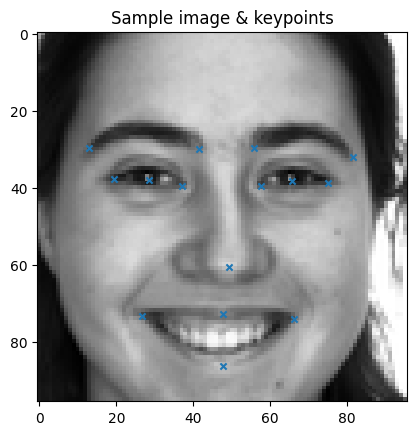

In [30]:
rand_sample=rand_img_selector(0,1500)
fig, axis = plt.subplots()
plot_kp(clean_train_images[rand_sample], clean_train_keypoints[rand_sample], axis, "Sample image & keypoints")

### Horizontal Flip

In [31]:
flipped_train_images, flipped_train_keypoints = horz_flip(clean_train_images, clean_train_keypoints)

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)


In [32]:
train_images=concatenate(train_images,flipped_train_images)
train_keypoints=concatenate(train_keypoints,flipped_train_keypoints)

New shape of training data:  (4280, 96, 96, 1)
New shape of training data:  (4280, 30)


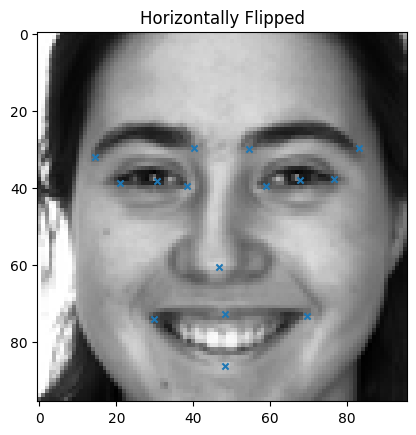

In [33]:
fig, axis = plt.subplots()
plot_kp(flipped_train_images[rand_sample], flipped_train_keypoints[rand_sample], axis, "Horizontally Flipped") 

### Angle Rotation

In [34]:
rotation_angles = [12]
rotated_train_images, rotated_train_keypoints = rotation(clean_train_images, clean_train_keypoints,rotation_angles)

Augmenting for angles (in degrees): 
12  -12  Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)


In [35]:
train_images=concatenate(train_images,rotated_train_images)
train_keypoints=concatenate(train_keypoints,rotated_train_keypoints)

New shape of training data:  (8560, 96, 96, 1)
New shape of training data:  (8560, 30)


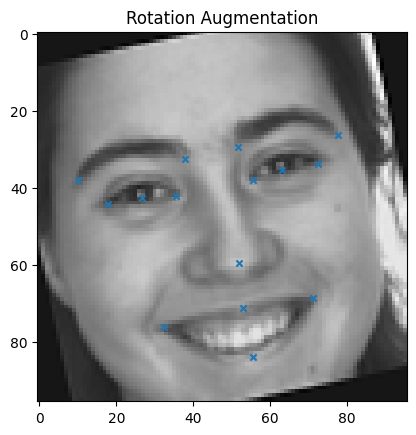

In [36]:
fig, axis = plt.subplots()
plot_kp(rotated_train_images[rand_sample], rotated_train_keypoints[rand_sample], axis, "Rotation Augmentation")

### **Brightness Adjustment**

In [37]:
bright_fact=0.5
dark_fact=1.5
bri_adj_train_images, bri_adj_train_keypoints = bri_adj(clean_train_images, clean_train_keypoints,bright_fact,dark_fact)

Shape of brightness adjusted images: (4280, 96, 96, 1)
Shape of brightness adjustedkeypoints: (4280, 30)


In [38]:
train_images=concatenate(train_images,bri_adj_train_images)
train_keypoints=concatenate(train_keypoints,bri_adj_train_keypoints)

New shape of training data:  (12840, 96, 96, 1)
New shape of training data:  (12840, 30)


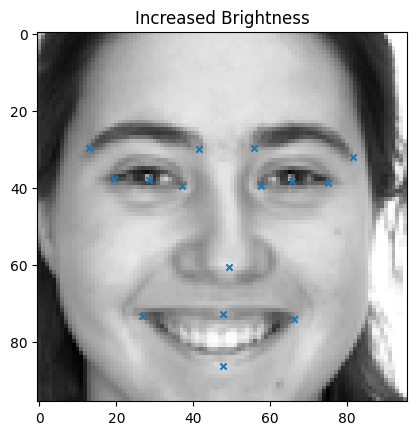

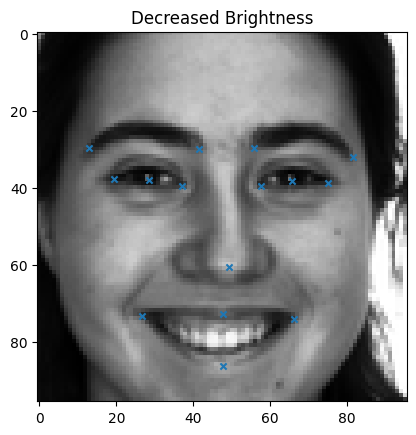

In [39]:
fig, axis = plt.subplots()
plot_kp(bri_adj_train_images[rand_sample], bri_adj_train_keypoints[rand_sample], axis, "Increased Brightness") 
fig, axis = plt.subplots()
plot_kp(bri_adj_train_images[len(bri_adj_train_images)//2+rand_sample], bri_adj_train_keypoints[len(bri_adj_train_images)//2+rand_sample], axis, "Decreased Brightness")

### **Pixel Shifting**

In [40]:
pixel_shifts = [12]
shifted_images, shifted_keypoints = img_shifting(clean_train_images, clean_train_keypoints,pixel_shifts)

Shape of shifted images: (6350, 96, 96, 1)
Shape of shifted keypoints: (6350, 30)


In [41]:
train_images=concatenate(train_images,shifted_images)
train_keypoints=concatenate(train_keypoints,shifted_keypoints)

New shape of training data:  (19190, 96, 96, 1)
New shape of training data:  (19190, 30)


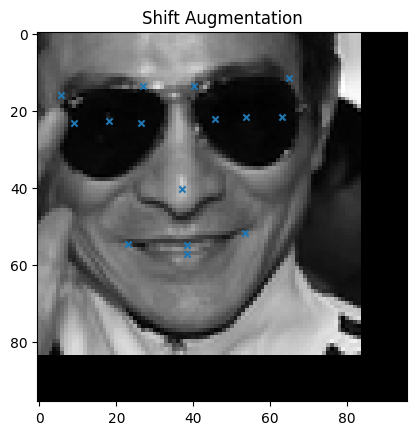

In [42]:
fig, axis = plt.subplots()
plot_kp(shifted_images[rand_sample], shifted_keypoints[rand_sample], axis, "Shift Augmentation")

### Noise Addition

In [43]:
noisy_train_images_rand = rand_noise(clean_train_images)

Shape of noisy_train_images: (2140, 96, 96, 1)


In [44]:
train_images=concatenate(train_images,noisy_train_images_rand)
train_keypoints=concatenate(train_keypoints,clean_train_keypoints)

New shape of training data:  (21330, 96, 96, 1)
New shape of training data:  (21330, 30)


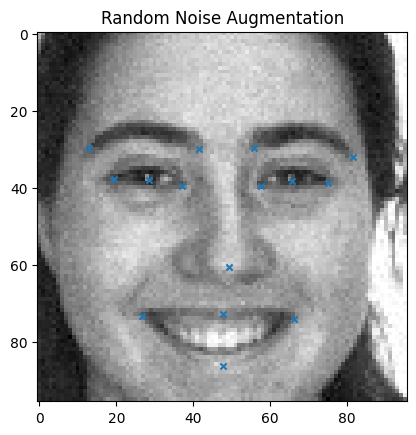

In [45]:
fig, axis = plt.subplots()
plot_kp(noisy_train_images_rand[rand_sample], clean_train_keypoints[rand_sample], axis, "Random Noise Augmentation")

In [46]:
noisy_train_images_gau = add_gaussian_noise(clean_train_images,0.05)

Shape of noisy_train_images: (2140, 96, 96, 1)


In [47]:
train_images=concatenate(train_images,noisy_train_images_gau)
train_keypoints=concatenate(train_keypoints,clean_train_keypoints)

New shape of training data:  (23470, 96, 96, 1)
New shape of training data:  (23470, 30)


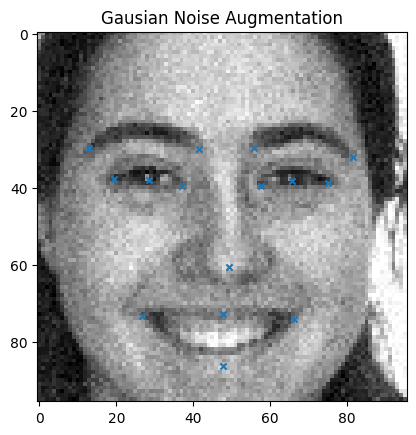

In [48]:
fig, axis = plt.subplots()
plot_kp(noisy_train_images_gau[rand_sample], clean_train_keypoints[rand_sample], axis, "Gausian Noise Augmentation")

In [49]:
noisy_train_images_poi = add_poisson_noise(clean_train_images,0.1)

Shape of noisy_train_images: (2140, 96, 96, 1)


In [50]:
train_images=concatenate(train_images,noisy_train_images_poi)
train_keypoints=concatenate(train_keypoints,clean_train_keypoints)

New shape of training data:  (25610, 96, 96, 1)
New shape of training data:  (25610, 30)


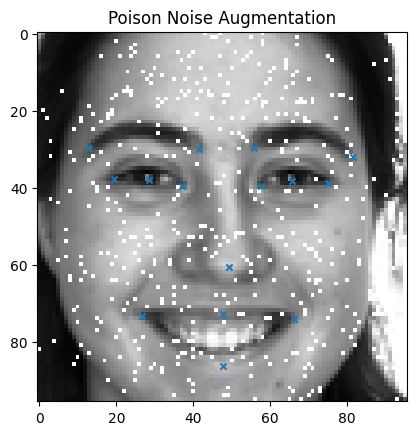

In [51]:
fig, axis = plt.subplots()
plot_kp(noisy_train_images_poi[rand_sample], clean_train_keypoints[rand_sample], axis, "Poison Noise Augmentation")

In [52]:
noisy_train_images_snp = add_salt_and_pepper_noise(clean_train_images, noise_amount=0.01)

In [53]:
train_images=concatenate(train_images,noisy_train_images_snp)
train_keypoints=concatenate(train_keypoints,clean_train_keypoints)

New shape of training data:  (27750, 96, 96, 1)
New shape of training data:  (27750, 30)


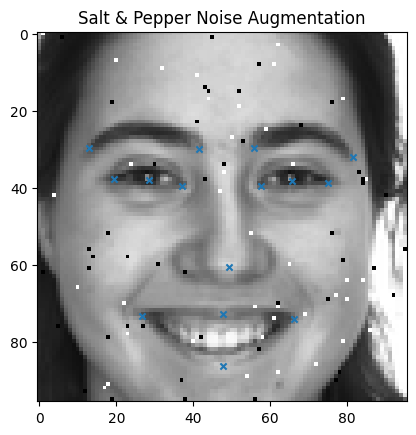

In [54]:
fig, axis = plt.subplots()
plot_kp(noisy_train_images_snp[rand_sample], clean_train_keypoints[rand_sample], axis, "Salt & Pepper Noise Augmentation")


 Dataset Name: Clean Trained Data

 


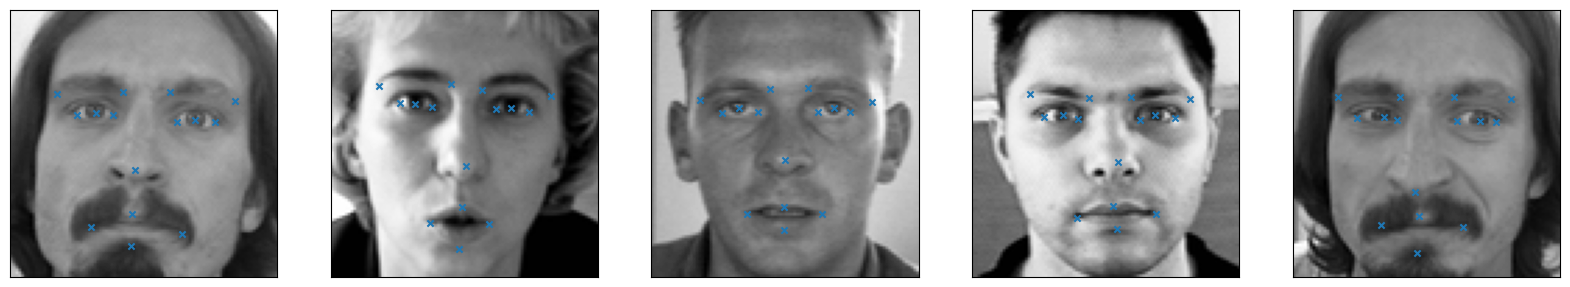


 Dataset Name: Horizontally Flipped Images

 


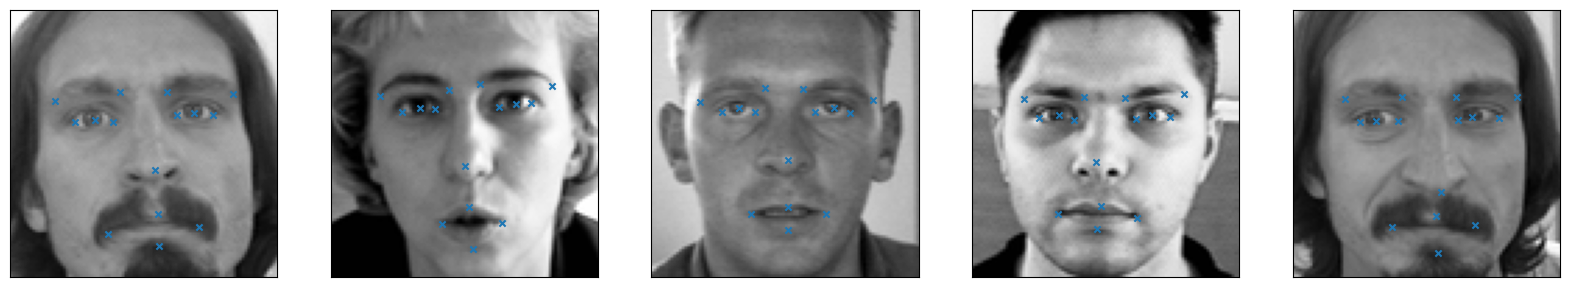


 Dataset Name: Rotated Data

 


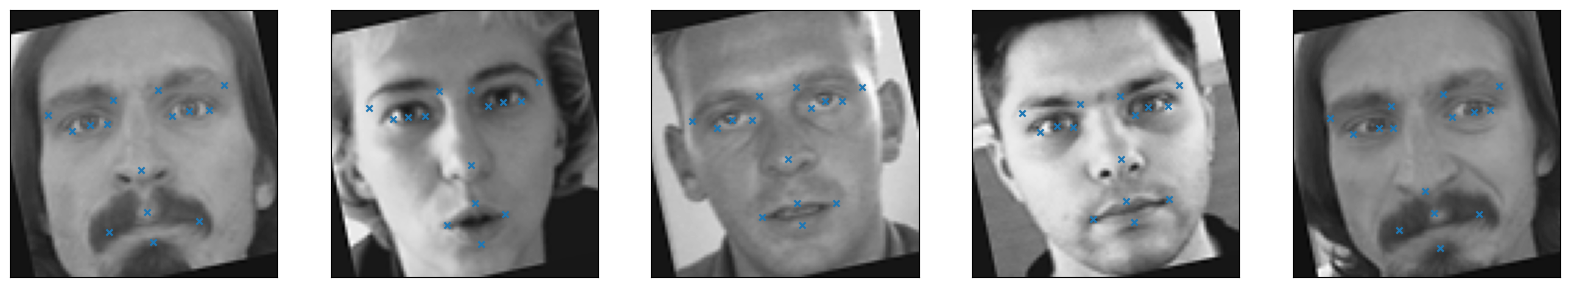


 Dataset Name: Brightness Adjusted (Increament)

 


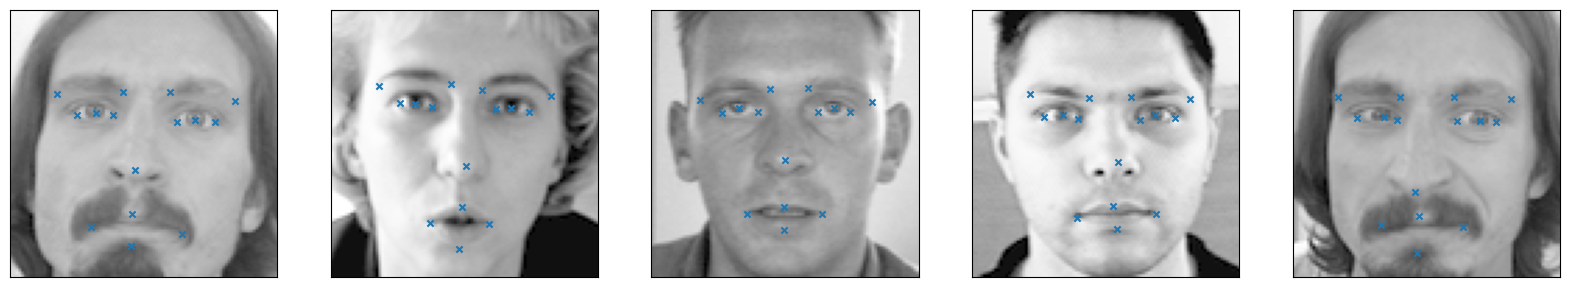


 Dataset Name: Brightness Adjusted (Decreament)

 


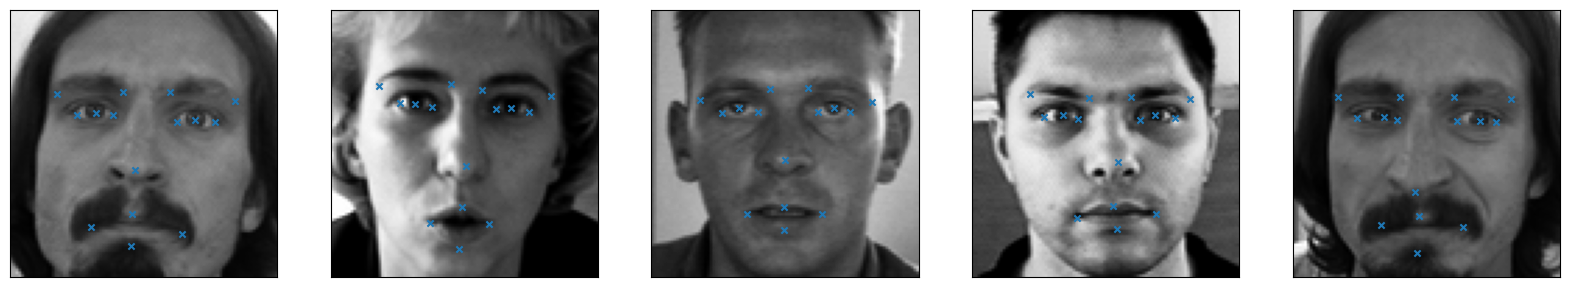


 Dataset Name: Shifted Images (Top_Left)

 


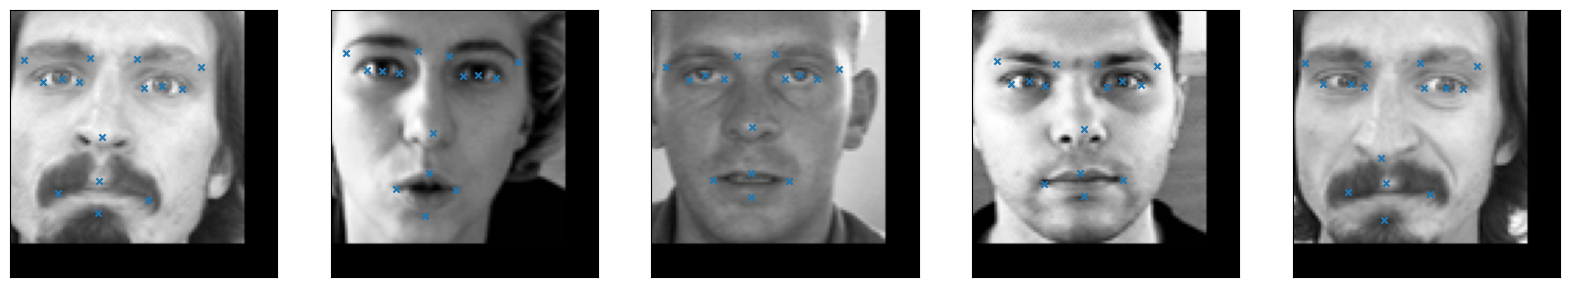


 Dataset Name: Shifted Images (Bottom_Left)

 


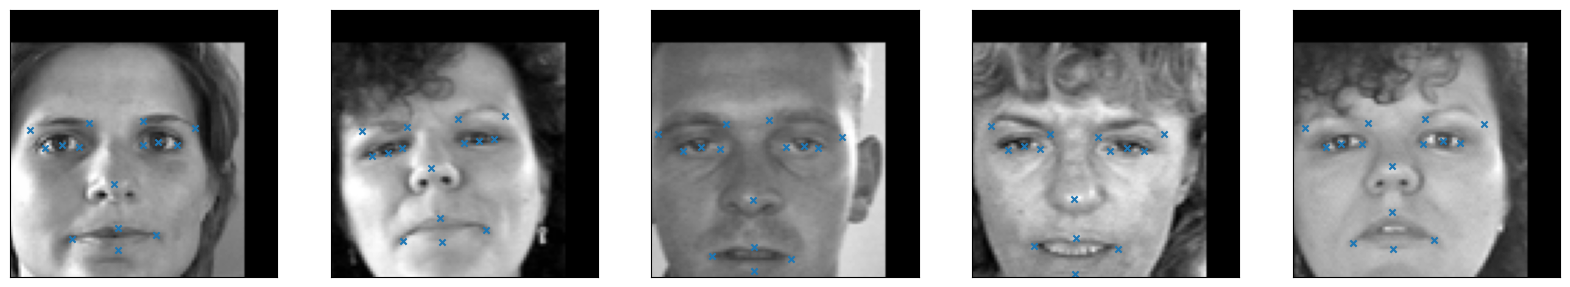


 Dataset Name: Random Noise

 


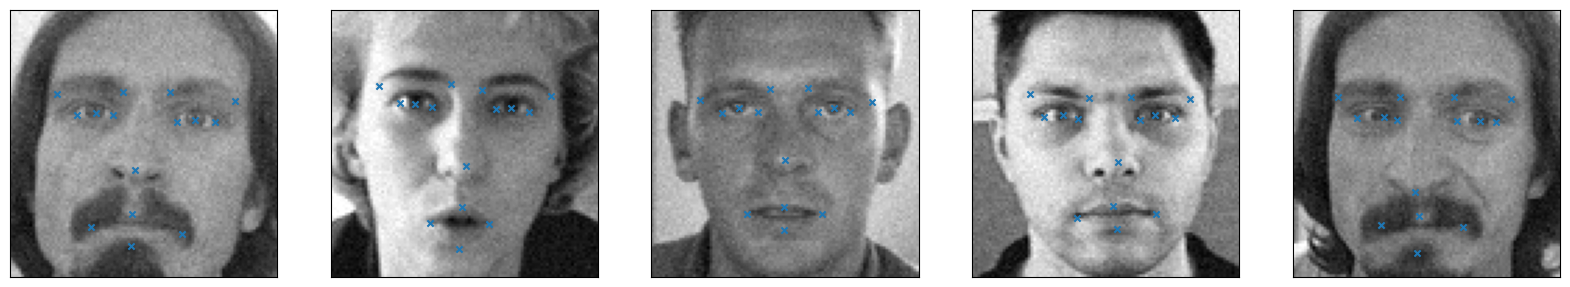


 Dataset Name: Gausian Noise

 


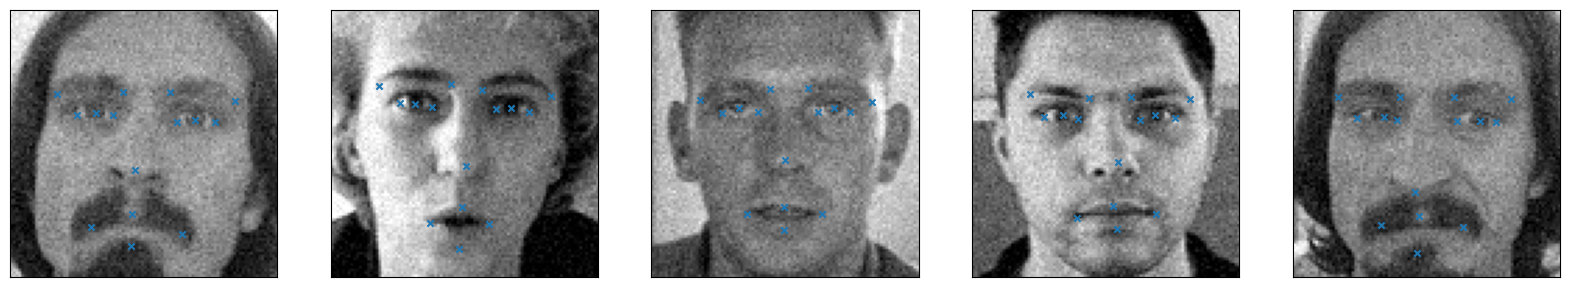


 Dataset Name: Poison Noise

 


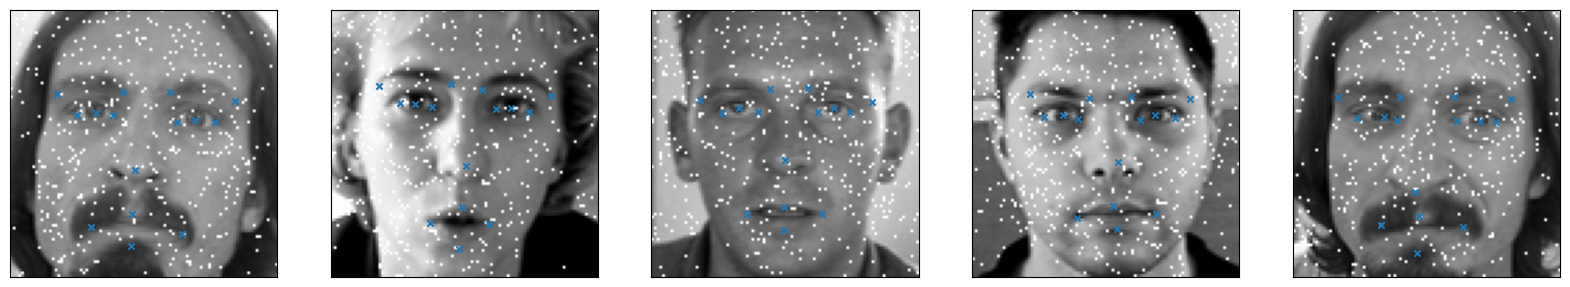


 Dataset Name: Salt and Pepper Noise

 


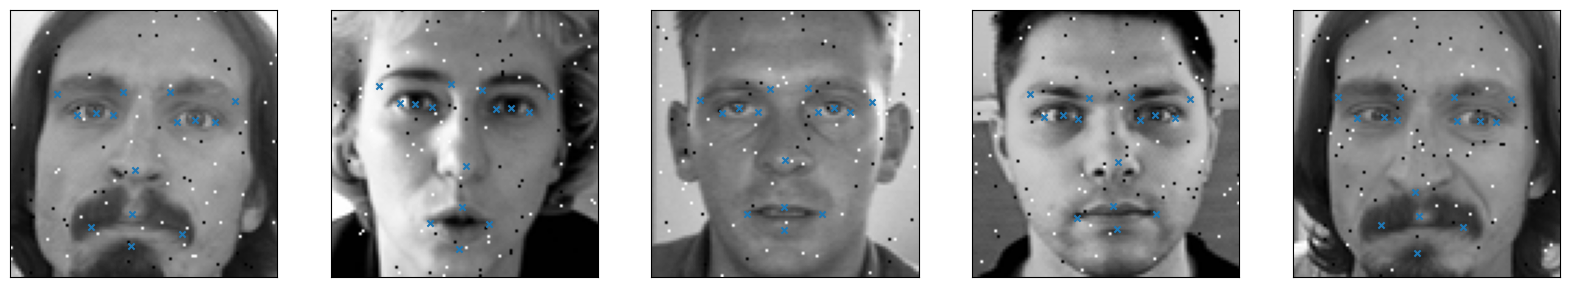

In [55]:
samp_img_list=[clean_train_images,flipped_train_images,rotated_train_images,bri_adj_train_images[0:2139],bri_adj_train_images[2140:3000], shifted_images[0:2139],shifted_images[2134:3000],noisy_train_images_rand,noisy_train_images_gau,noisy_train_images_poi,noisy_train_images_snp ]
samp_kp_list=[clean_train_keypoints,flipped_train_keypoints,rotated_train_keypoints, bri_adj_train_keypoints[0:2139],bri_adj_train_keypoints[2140:3000], shifted_keypoints[0:2139],shifted_keypoints[2134:3000],clean_train_keypoints,clean_train_keypoints,clean_train_keypoints,clean_train_keypoints]
image_list_name=["Clean Trained Data", "Horizontally Flipped Images", "Rotated Data", "Brightness Adjusted (Increament)", "Brightness Adjusted (Decreament)", "Shifted Images (Top_Left)","Shifted Images (Bottom_Left)","Random Noise","Gausian Noise","Poison Noise","Salt and Pepper Noise"]
plot_all_samples(samp_img_list,samp_kp_list,image_list_name)

### **Train Test Split**

In [56]:
train_images_split, test_images_split, train_keypoints_split, test_keypoints_split=test_selection(train_images, train_keypoints,0.2)

train_images_split shape: (22200, 96, 96, 1)
train_keypoints_split shape: (22200, 30)
test_images_split shape: (5550, 96, 96, 1)
test_keypoints_split shape (5550, 30)


### **Model Definition**

In [57]:
model=get_model_architecture()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        288       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9216      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                        

### **Model Compilation**

In [58]:
history=model_training(model)

Epoch 1/100
660/660 [==============================] - 44s 40ms/step - loss: 67.2275 - mae: 5.0915 - acc: 0.5870 - val_loss: 37.0979 - val_mae: 3.7797 - val_acc: 0.6829
Epoch 2/100
660/660 [==============================] - 25s 38ms/step - loss: 31.5679 - mae: 3.5393 - acc: 0.6659 - val_loss: 39.4191 - val_mae: 3.8436 - val_acc: 0.6495
Epoch 3/100
660/660 [==============================] - 26s 39ms/step - loss: 25.8632 - mae: 3.1772 - acc: 0.6867 - val_loss: 28.1489 - val_mae: 3.6259 - val_acc: 0.7117
Epoch 4/100
660/660 [==============================] - 26s 39ms/step - loss: 22.8303 - mae: 2.9643 - acc: 0.7084 - val_loss: 22.4327 - val_mae: 3.0357 - val_acc: 0.7162
Epoch 5/100
660/660 [==============================] - 26s 39ms/step - loss: 19.2985 - mae: 2.7033 - acc: 0.7190 - val_loss: 22.0024 - val_mae: 3.0372 - val_acc: 0.7117
Epoch 6/100
660/660 [==============================] - 26s 40ms/step - loss: 17.2025 - mae: 2.5914 - acc: 0.7296 - val_loss: 16.0032 - val_mae: 2.1833 - va

### **Plotting Accuracies and Loss**

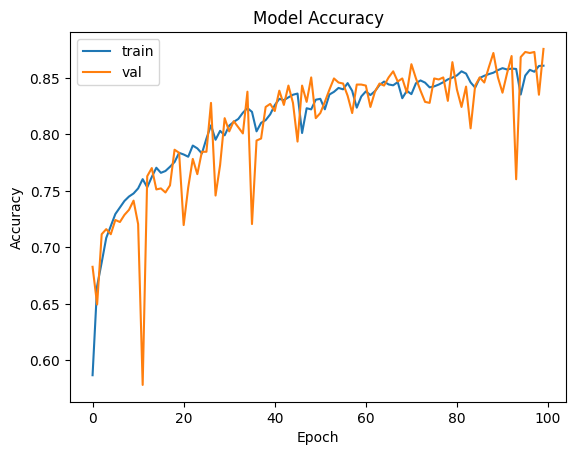

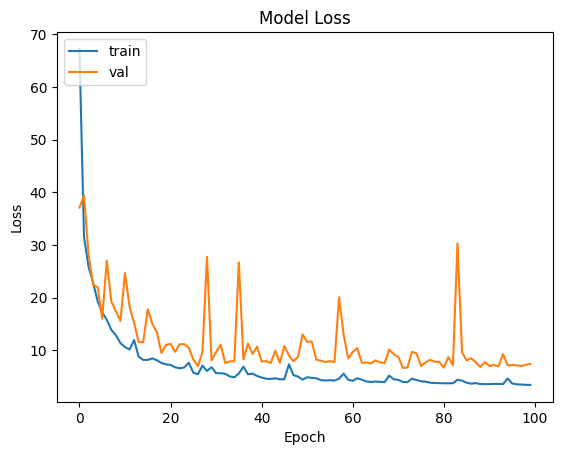

In [59]:
plot_accuracy(history)
plot_loss(history)

### **Model Evaluation**

In [60]:
test_preds = get_predictions(test_images_split,model)

174/174 [==============================] - 3s 14ms/step
shape of test predictions: (5550, 30)


In [61]:
evaluate_model(test_images_split, test_keypoints_split, model)

174/174 [==============================] - 2s 13ms/step - loss: 10.8905 - mae: 1.3544 - acc: 0.8715


(10.890477180480957, 1.354392409324646)

In [62]:
RMSE_cal(test_keypoints_split,test_preds)

RMSE on testing set:  3.300072255048189


### **Plotting Test Prediction on Test Set**

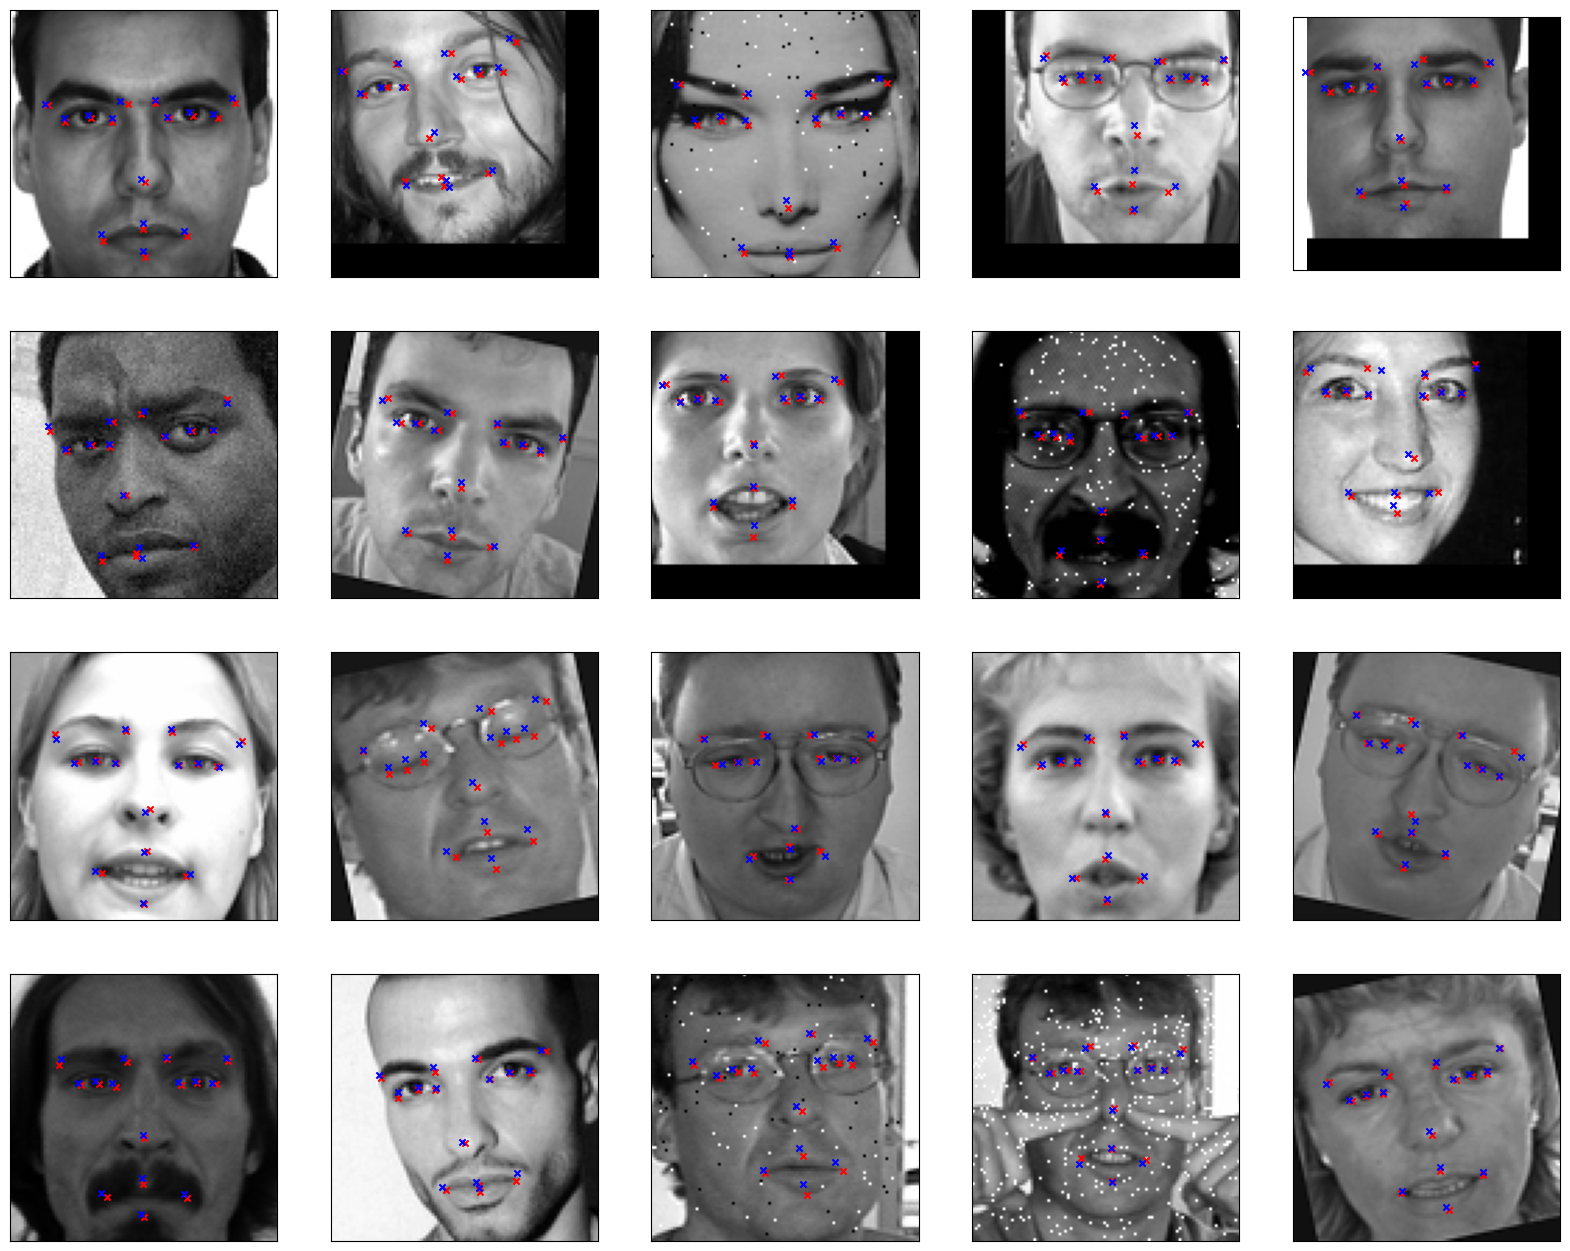

In [63]:
plot_test(test_images_split, test_keypoints_split, test_preds )